An attempt to predict the win probability of the teams in a given match at the end of each over and to look at the important factors affecting the match output.

**Objective :** 
To predict the win probability of SRH at the end of each over for the finals of IPL season 2016.

**Training data :**
All other matches played during 2016 season 

Let us first import the necessary modules.!

In [36]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_columns', 50)

Load the dataset and look at the top few rows to get an idea about the data. 

If you want to know more about the data, please look at the kernel here

In [37]:
data_path = ""
score_df = pd.read_csv(data_path+"deliveries.csv")
match_df = pd.read_csv(data_path+"matches.csv")
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In this analysis, we are going to look at the matches played only during the latest season 2016. So let us subset the dataset to get only these rows. 

Also some matches are affected by rain and hence Duckworth-Lewis method are used for these matches and so using these matches for training our model might cause some error in our training and so let us neglect those matches as well.

In [38]:
match_df['season'].unique()

array([2017, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018,
       2019], dtype=int64)

In [39]:
# Let us take only the matches played in 2016 for this analysis #

# for our use case
#match_df = match_df.loc[match_df.season.isin([2016,2017,2018,2019]),:]
#match_df = match_df.loc[match_df.dl_applied == 0,:]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


Okay. Now that we are done with the pre-processing, let us create the variables that are needed for building our model. 

Some of the important variables which I could think of are the following:

1. Runs scored in the last over
2. Wickets taken in the last over
3. Total score of the innings
4. Total wickets 
5. Target that the team is chasing down
6. Remaining target
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary variables on whether the team for which we are predicting is batting team or bowling team

There are several other variables which we can create including

1. Team name
2. Opponent team name
3. Score in the last 'n' overs
4. Players who are batting
5. Player who is bowling and so on.

But ours is a good set of variables to start with.



In [40]:
# get match id where toss was won by team 1 and toss decision was field #
match_id_toss_win_field = match_df.loc[(match_df.toss_winner == match_df.Team1) & (match_df.TossDecision == 'field'),['ID']]
match_id_toss_win_field.head()

AttributeError: 'DataFrame' object has no attribute 'TossWinner'

In [16]:
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [150]:
# runs and wickets per over #
score_df = pd.merge(score_df, match_df[['id','season','city','toss_decision','toss_winner','venue','winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].loc[score_df['player_dismissed'] != 0] = 1
train_df = score_df.groupby(['match_id','city','inning','toss_decision','toss_winner','venue','over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns = train_df.columns.get_level_values(0)

# innings score and wickets #

train_df['player_dismissed'] = train_df['player_dismissed'].astype('int')
train_df['innings_wickets'] = train_df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
train_df.head()

# Get the target column #
temp_df = train_df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
temp_df = temp_df.loc[temp_df['inning']==1,:]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'score_target']
train_df = train_df.merge(temp_df, how='left', on = ['match_id', 'inning'])
train_df['score_target'].fillna(-1, inplace=True)

#train_df = train_df.loc[train_df['inning'].isin([1,2]),:]

# get the remaining target #
def get_remaining_target(row):
    if row['score_target'] == -1.:
        return -1
    else:
        return row['score_target'] - row['innings_score']

train_df['remaining_target'] = train_df.apply(lambda row: get_remaining_target(row),axis=1)

# get the run rate #
train_df['run_rate'] = train_df['innings_score'] / train_df['over']

# get the remaining run rate #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)
train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['target'] = (train_df['team1'] == train_df['winner']).astype('int')

train_df.head()

C:\Users\majumder_souptik@lilly.com\AppData\Local\Temp\ipykernel_29160\2170064116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['player_dismissed'].loc[score_df['player_dismissed'] != 0] = 1


,match_id,city,inning,toss_decision,toss_winner,venue,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,518,Mumbai,1,bat,Mumbai Indians,Wankhede Stadium,1,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,8,0,0,8,-1.0,-1.0,8.000000,-1.0,-1.0,1,0
1,518,Mumbai,1,bat,Mumbai Indians,Wankhede Stadium,2,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,4,1,1,12,-1.0,-1.0,6.000000,-1.0,-1.0,1,0
2,518,Mumbai,1,bat,Mumbai Indians,Wankhede Stadium,3,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,8,0,1,20,-1.0,-1.0,6.666667,-1.0,-1.0,1,0
3,518,Mumbai,1,bat,Mumbai Indians,Wankhede Stadium,4,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,9,1,2,29,-1.0,-1.0,7.250000,-1.0,-1.0,1,0
4,518,Mumbai,1,bat,Mumbai Indians,Wankhede Stadium,5,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,1,2,4,30,-1.0,-1.0,6.000000,-1.0,-1.0,1,0


Now let us split the data and keep the final match as our validation sample.

In [153]:
train_df['match_id'].unique()

array([518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530,
       531, 532, 533, 534, 535, 536, 537, 538, 540, 541, 542, 543, 544,
       545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557,
       558, 559, 560, 561, 563, 564, 565, 568, 569, 570, 571, 572, 573,
       574, 575, 576, 577], dtype=int64)

In [154]:
# get match id where innings is 1 and toss winner is team1 and toss decision is field #
train_df.loc[(train_df['toss_winner']==train_df['team2']) & (train_df['toss_decision']=='field'), 'match_id'].unique()

array([519, 520, 521, 522, 524, 526, 528, 529, 530, 531, 532, 533, 534,
       535, 537, 538, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549,
       550, 551, 552, 553, 554, 555, 556, 558, 559, 561, 564, 565, 568,
       569, 571, 572, 573, 574, 575, 576], dtype=int64)

In [114]:
#combine city and venue in one single column#
#train_df['city_venue'] = train_df['city'].astype(str) + '_' + train_df['venue'].astype(str)
train_df.drop('venue', axis=1, inplace=True)
train_df.drop('city', axis=1, inplace=True)
train_df.drop('toss_decision', axis=1, inplace=True)

# cnvert toss decision to bat = 1 and field = 0 #
#train_df['toss_decision'] = (train_df['toss_decision'] == 'bat').astype('int')
#train_df.drop('toss_decision', axis=1, inplace=True)
train_df['is_toss_winner'] = (train_df['toss_winner'] == train_df['team1']).astype('int')

In [115]:
train_df.head()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
0,1,1,Royal Challengers Bangalore,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1,1,0
1,1,1,Royal Challengers Bangalore,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,16,1,1,23,-1.0,-1.0,11.500000,-1.0,-1.0,1,1,0
2,1,1,Royal Challengers Bangalore,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,6,0,1,29,-1.0,-1.0,9.666667,-1.0,-1.0,1,1,0
3,1,1,Royal Challengers Bangalore,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,4,0,1,33,-1.0,-1.0,8.250000,-1.0,-1.0,1,1,0
4,1,1,Royal Challengers Bangalore,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,9,0,1,42,-1.0,-1.0,8.400000,-1.0,-1.0,1,1,0


In [116]:
# add a column run_rate_imp whose value will be run rate for 1st innings and run rate diff for 2nd innings #
def get_run_rate_imp(row):
    if row['is_batting_team'] == 1:
        return row['run_rate']
    else:
        return row['runrate_diff']

#train_df['run_rate_imp'] = train_df.apply(lambda row: get_run_rate_imp(row), axis=1)
# drop run_rate and runrate_diff #
#train_df.drop('run_rate', axis=1, inplace=True)

In [117]:
train_df.tail()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
8944,11415,2,Mumbai Indians,16,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,20,0,4,112,152.0,40.0,7.000000,10.000000,-3.000000,0,1,1
8945,11415,2,Mumbai Indians,17,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,5,0,4,117,152.0,35.0,6.882353,11.666667,-4.784314,0,1,1
8946,11415,2,Mumbai Indians,18,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,20,0,4,137,152.0,15.0,7.611111,7.500000,0.111111,0,1,1
8947,11415,2,Mumbai Indians,19,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,13,1,5,150,152.0,2.0,7.894737,2.000000,5.894737,0,1,1
8948,11415,2,Mumbai Indians,20,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,7,2,7,157,152.0,-5.0,7.850000,99.000000,-91.150000,0,1,1


In [118]:
#drop run_rate and runrate_diff#
#train_df.drop('run_rate', axis=1, inplace=True)
#train_df.drop('runrate_diff', axis=1, inplace=True)

In [119]:
# set xcols to all columns except the ones in remove_cols
x_cols = [x for x in train_df.columns if x not in ['match_id','venue','city','toss_winner','team1', 'team2', 'batting_team', 'winner', 'target']]

print(x_cols)
print(len(x_cols))

# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.loc[train_df.match_id == 11343,:]
dev_df = train_df.loc[train_df.match_id != 11343,:]

['inning', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team', 'is_toss_winner']
13


In [120]:
val_df.loc[val_df['inning']==1].tail()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
8616,11343,1,Kolkata Knight Riders,16,Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,Kolkata Knight Riders,7,0,4,133,-1.0,-1.0,8.312500,-1.0,-1.0,1,0,0
8617,11343,1,Kolkata Knight Riders,17,Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,Kolkata Knight Riders,15,0,4,148,-1.0,-1.0,8.705882,-1.0,-1.0,1,0,0
8618,11343,1,Kolkata Knight Riders,18,Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,Kolkata Knight Riders,5,1,5,153,-1.0,-1.0,8.500000,-1.0,-1.0,1,0,0
8619,11343,1,Kolkata Knight Riders,19,Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,Kolkata Knight Riders,11,1,6,164,-1.0,-1.0,8.631579,-1.0,-1.0,1,0,0
8620,11343,1,Kolkata Knight Riders,20,Kings XI Punjab,Kolkata Knight Riders,Kings XI Punjab,Kolkata Knight Riders,22,0,6,186,-1.0,-1.0,9.300000,-1.0,-1.0,1,0,0


### checking multicollinearities

In [75]:
# calculate VIF score for all columns in dev_df #
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dev_df[x_cols].values, i) for i in range(dev_df[x_cols].shape[1])]
vif["features"] = x_cols
vif


,VIF Factor,features
0,68.572588,inning
1,113.138969,over
2,6.061477,total_runs
3,1.776808,player_dismissed
4,9.146118,innings_wickets
5,91.122496,innings_score
6,67.902890,score_target
7,10.480404,remaining_target
8,60.133570,run_rate
9,254.506068,required_run_rate


In [76]:
# drop over and recalculate VIF score #
x_cols = [x for x in x_cols if x not in ['over','inning','run_rate_imp','score_target','required_run_rate','run_rate','innings_score']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dev_df[x_cols].values, i) for i in range(dev_df[x_cols].shape[1])]
vif["features"] = x_cols
vif

,VIF Factor,features
0,3.354965,total_runs
1,1.655470,player_dismissed
2,2.821508,innings_wickets
3,1.877717,remaining_target
4,1.195938,runrate_diff
5,2.510675,is_batting_team
6,1.188092,is_toss_winner


In [77]:
# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['target'])
val_X = np.array(val_df[x_cols[:]])[:-1,:]
val_y = np.array(val_df['target'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

(8911, 7) (8911,)
(37, 7) (37,)


In [78]:
# show train_df for innings 2 #
dev_df.loc[dev_df['inning']==2,:].head()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
20,1,2,Royal Challengers Bangalore,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,11,0,0,11,207.0,196.0,11.000000,10.315789,0.684211,0,1,0
21,1,2,Royal Challengers Bangalore,2,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,1,0,0,12,207.0,195.0,6.000000,10.833333,-4.833333,0,1,0
22,1,2,Royal Challengers Bangalore,3,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,16,0,0,28,207.0,179.0,9.333333,10.529412,-1.196078,0,1,0
23,1,2,Royal Challengers Bangalore,4,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,15,0,0,43,207.0,164.0,10.750000,10.250000,0.500000,0,1,0
24,1,2,Royal Challengers Bangalore,5,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,5,0,0,48,207.0,159.0,9.600000,10.600000,-1.000000,0,1,0


In [79]:
val_df.head()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
8716,11346,1,Kings XI Punjab,1,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1,0,0
8717,11346,1,Kings XI Punjab,2,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,14,-1.0,-1.0,7.000000,-1.0,-1.0,1,0,0
8718,11346,1,Kings XI Punjab,3,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,9,0,0,23,-1.0,-1.0,7.666667,-1.0,-1.0,1,0,0
8719,11346,1,Kings XI Punjab,4,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,30,-1.0,-1.0,7.500000,-1.0,-1.0,1,0,0
8720,11346,1,Kings XI Punjab,5,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,8,1,1,38,-1.0,-1.0,7.600000,-1.0,-1.0,1,0,0


We shall use Xgboost for our modeling. Let us create a custom function for the same.

In [80]:
# define the function to create the model #
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

Now we are all set to build our model and make predictions. 

In [81]:
# let us build the model and get predcition for the final match #
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

[01:04:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [82]:
preds

array([0.423626  , 0.423626  , 0.4830764 , 0.423626  , 0.38020974,
       0.39731482, 0.40004048, 0.3739848 , 0.40044555, 0.44620407,
       0.42656514, 0.40004048, 0.3880279 , 0.40026972, 0.4849848 ,
       0.4849848 , 0.3822442 , 0.4278911 , 0.42749304, 0.3646903 ,
       0.36890593, 0.16391033, 0.0601951 , 0.04034279, 0.03645625,
       0.04206266, 0.0177117 , 0.0198663 , 0.01804396, 0.01915228,
       0.02185083, 0.01605553, 0.01945477, 0.01520348, 0.01635589,
       0.01373184, 0.02317392], dtype=float32)

**Important variables:**

Now that we have built our model, let us look at the important variables that contribute to the win.

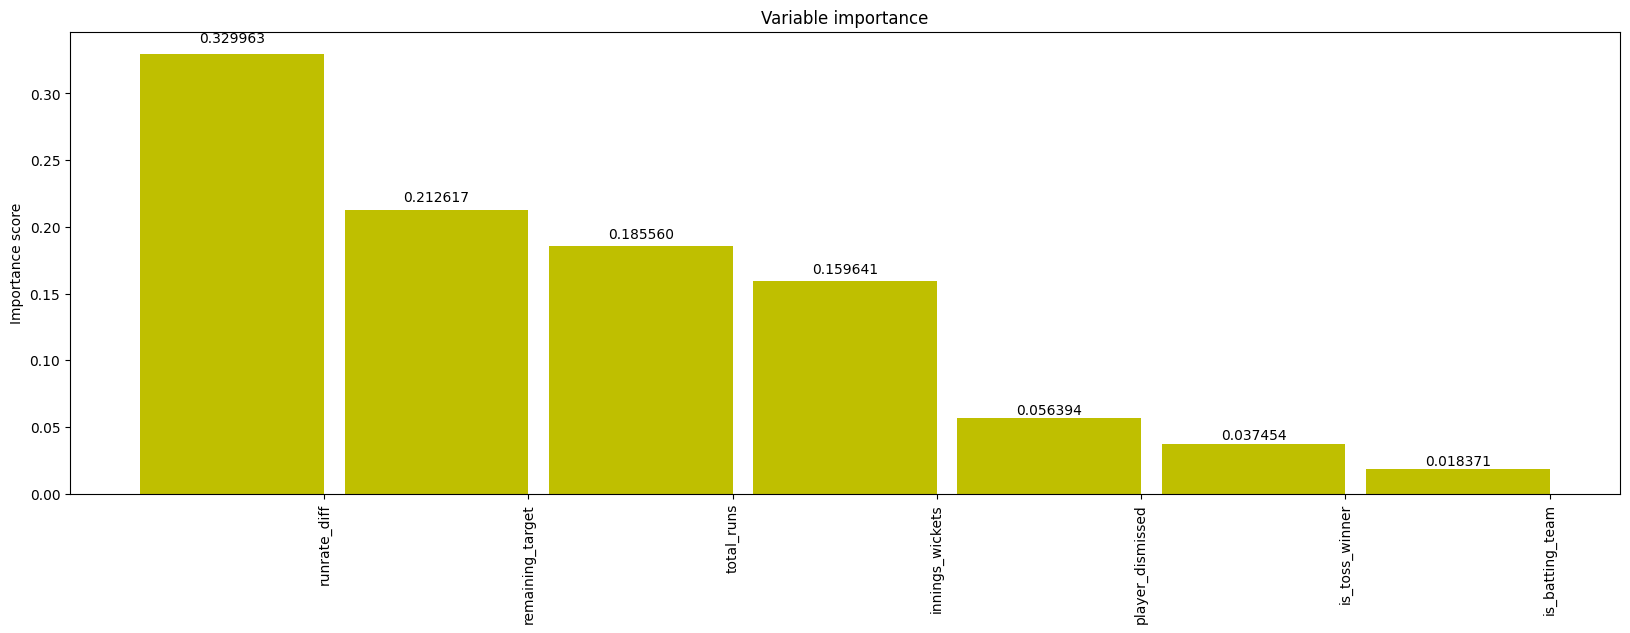

In [83]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\tq\n'.format(feat))
    outfile.close()

create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
feature_names = [line.split('\t')[0] for line in open('xgb.fmap')]
importance = {feature_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
         
labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(20,6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()

In [84]:
preds

array([0.423626  , 0.423626  , 0.4830764 , 0.423626  , 0.38020974,
       0.39731482, 0.40004048, 0.3739848 , 0.40044555, 0.44620407,
       0.42656514, 0.40004048, 0.3880279 , 0.40026972, 0.4849848 ,
       0.4849848 , 0.3822442 , 0.4278911 , 0.42749304, 0.3646903 ,
       0.36890593, 0.16391033, 0.0601951 , 0.04034279, 0.03645625,
       0.04206266, 0.0177117 , 0.0198663 , 0.01804396, 0.01915228,
       0.02185083, 0.01605553, 0.01945477, 0.01520348, 0.01635589,
       0.01373184, 0.02317392], dtype=float32)

In [85]:
len(preds)

37

In [86]:
val_df.head()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
8716,11346,1,Kings XI Punjab,1,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1,0,0
8717,11346,1,Kings XI Punjab,2,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,14,-1.0,-1.0,7.000000,-1.0,-1.0,1,0,0
8718,11346,1,Kings XI Punjab,3,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,9,0,0,23,-1.0,-1.0,7.666667,-1.0,-1.0,1,0,0
8719,11346,1,Kings XI Punjab,4,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,30,-1.0,-1.0,7.500000,-1.0,-1.0,1,0,0
8720,11346,1,Kings XI Punjab,5,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,8,1,1,38,-1.0,-1.0,7.600000,-1.0,-1.0,1,0,0


In [87]:
val_df.loc[val_df['inning']==1,:].head()

,match_id,inning,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target,is_toss_winner
8716,11346,1,Kings XI Punjab,1,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,7,-1.0,-1.0,7.000000,-1.0,-1.0,1,0,0
8717,11346,1,Kings XI Punjab,2,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,14,-1.0,-1.0,7.000000,-1.0,-1.0,1,0,0
8718,11346,1,Kings XI Punjab,3,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,9,0,0,23,-1.0,-1.0,7.666667,-1.0,-1.0,1,0,0
8719,11346,1,Kings XI Punjab,4,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,7,0,0,30,-1.0,-1.0,7.500000,-1.0,-1.0,1,0,0
8720,11346,1,Kings XI Punjab,5,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,Kings XI Punjab,8,1,1,38,-1.0,-1.0,7.600000,-1.0,-1.0,1,0,0


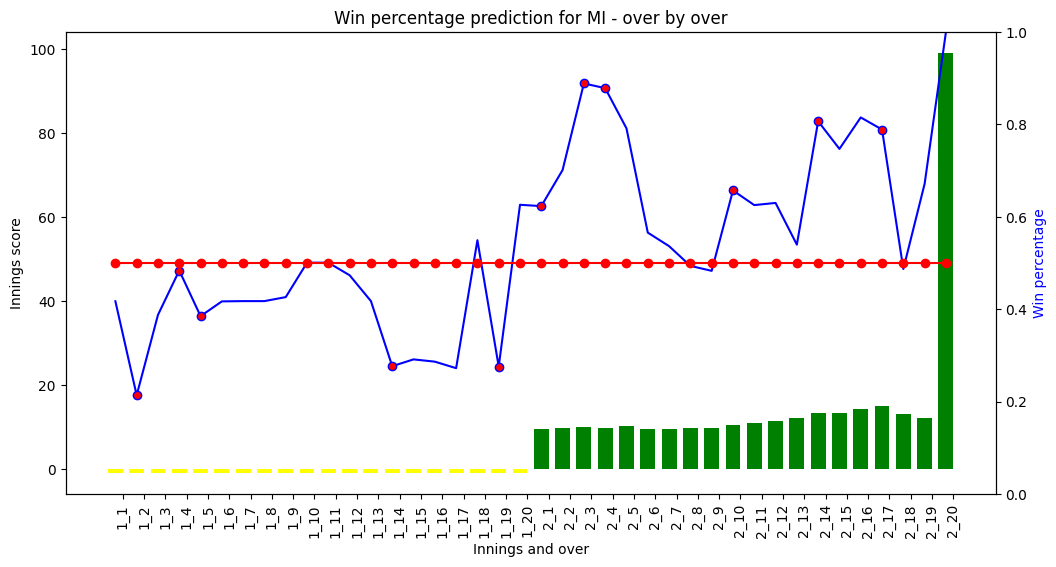

['yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']


In [32]:
out_df = pd.DataFrame({'Team1':val_df.team1.values}) #mumbai indians for colab data
out_df['is_batting_team'] = val_df.is_batting_team.values
out_df['Team2'] = val_df.team2.values
out_df['innings_over'] = np.array(val_df.apply(lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = val_df.innings_score.values
out_df['innings_wickets'] = val_df.innings_wickets.values
#out_df['score_target'] = val_df.score_target.values
out_df['total_runs'] = val_df.total_runs.values
out_df['predictions'] = list(preds)+[1]
#out_df['run_rate_imp'] = val_df.run_rate_imp.values
out_df['wickets_in_over'] = val_df.player_dismissed.values
out_df['required_run_rate'] = val_df.required_run_rate.values


fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['required_run_rate']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")


# get indices as a list where player is dismissed
wicket_indices = [i for i, x in enumerate(out_df['wickets_in_over']) if x == 1]
ax2.plot(ind, np.array(out_df['predictions']), color='b' ,markevery=wicket_indices,markerfacecolor='red',marker='o' )
ax2.plot(ind, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()
print(['yellow']*20 + ['green']*20)

Yellow bar represents the scores in the corresponding overs played by MI while green is for CSK. 

Red line represents the equal win probability and blue line represents the win probability of MI at the end of each over. 

As we can see, it was generally above 0.5 for most part of the first innings, and down for first few overs in second innings but things changed in the last over.

So let us look at the same graph by using the number of runs scored in that over in place of overall runs.

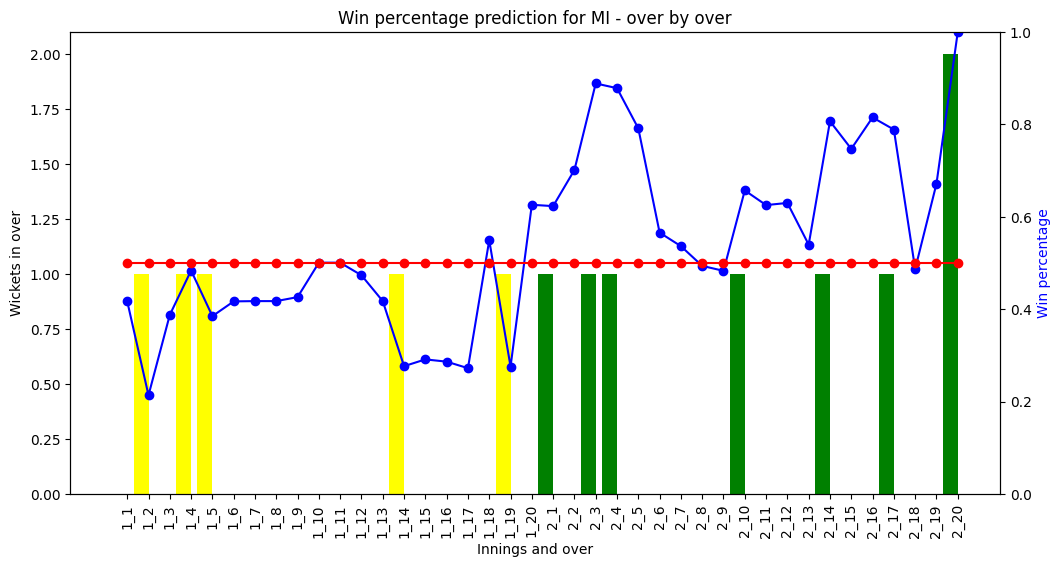

In [33]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['wickets_in_over']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Wickets in over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()

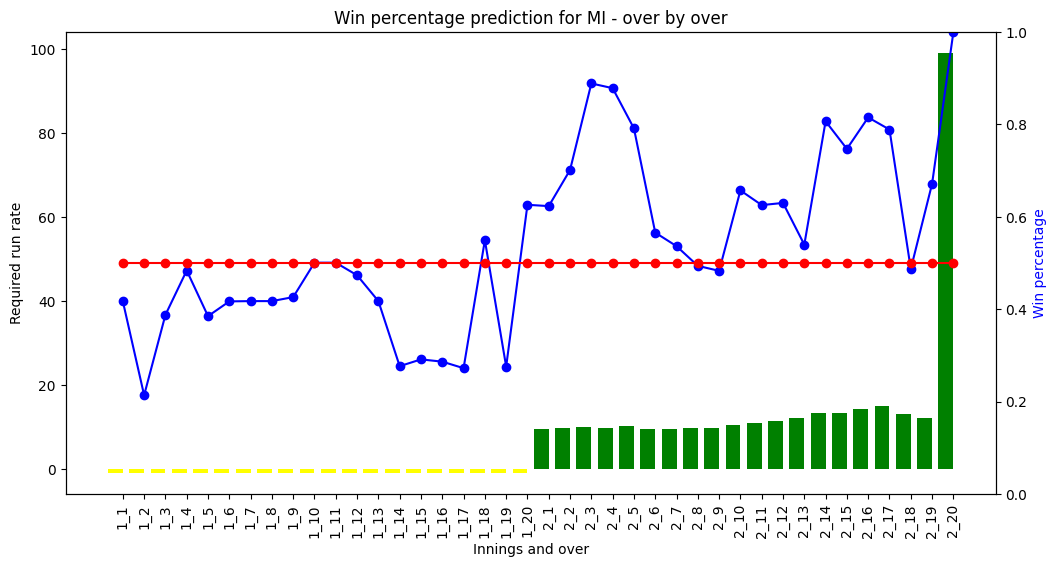

In [34]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['required_run_rate']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Required run rate")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()

In [35]:
# save and load the model to a pickle file
import pickle
pickle.dump(model, open("model.pkl", "wb"))

In [36]:
x_cols

['total_runs',
 'player_dismissed',
 'innings_wickets',
 'remaining_target',
 'runrate_diff',
 'is_batting_team',
 'is_toss_winner']